<a target="_blank" href="https://colab.research.google.com/github/lamm-mit/MechAgents/blob/main/1_colab_notebook_for_MulAgentGroup_LE/0_MultiGen_MultiStep_LE.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# A multi-agent group with division of labor solves linear elasticity problems of various flavors
Reference:
Ni, Bo, and Markus J. Buehler. "MechAgents: Large language model multi-agent collaborations can solve mechanics problems, generate new data, and integrate knowledge." Extreme Mechanics Letters (2024)

# Tasks checked:
> 1. solve uniaxial tension
> 2. change tension into shear
> 3. refine the mesh for better results
> 4. change the geometry (i.e., add a hole in the middle)
> 5. postprocess: plot stress_xy

# 0. Prepare the packages for make it easier

In [1]:
# prepare fenics for colab
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2023-11-05 21:13:03--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-11-05 21:13:03 (42.5 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/af0ba58/releases/pybind11-install.s

In [2]:
try:
    import chromadb
except ImportError:
    !pip install chromadb==0.4.15
    import chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.8/479.8 kB 7.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.9/103.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.7/59

In [3]:
try:
    import tiktoken
except ImportError:
    !pip install tiktoken==0.5.1
    import tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.2 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


In [4]:
try:
    import pypdf
except ImportError:
    !pip install pypdf==3.17.0
    import pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.4/277.4 kB 6.2 MB/s eta 0:00:00a 0:00:01


In [5]:
# add autogen
#
try:
    import autogen
except ImportError:
    !pip install pyautogen==0.1.14
    import autogen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 10.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


# 1. Working part

### Test the group chat: agentchat_groupchat_RAG.ipynb

## 1.1 Set the API endpoint

In [6]:
import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    file_location=".",
    filter_dict={
        "model": ["gpt-3.5-turbo", "gpt-35-turbo", "gpt-35-turbo-0613", "gpt-4", "gpt4", "gpt-4-32k"],
    },
)

print("LLM models: ", [config_list[i]["model"] for i in range(len(config_list))])

LLM models:  []


In [24]:
# here, we set it locally
config_list_gpt = [
    {
        "model": "gpt-4",
        "api_key": "Your openAI API key"
    }
]


## 1.2 Construct agents

In [28]:
# gpt4_config = {
#     "seed": 42,  # change the seed for different trials
#     "temperature": 0,
#     "config_list": config_list_gpt,
#     "request_timeout": 240,
# }

gpt4_config = {
    "seed": 42,  # change the seed for different trials
    "temperature": 0,
    "config_list": config_list_gpt,
    "request_timeout": 600,
    "retry_wait_time": 120,
}


In [29]:
user_proxy = autogen.UserProxyAgent(
   name="Admin",
   system_message="A human admin. Interact with the planner to discuss the plan. Plan execution needs to be approved by this admin.",
   code_execution_config=False,
)

# engineer = autogen.AssistantAgent(
#     name="Engineer",
#     llm_config=gpt4_config,
#     system_message='''Engineer. You follow an approved plan. You write python/shell code to solve tasks. Wrap the code in a code block that specifies the script type. The user can't modify your code. So do not suggest incomplete code which requires others to modify. Don't use a code block if it's not intended to be executed by the executor.
# Don't include multiple code blocks in one response. Do not ask others to copy and paste the result. Check the execution result returned by the executor.
# If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
# ''',
# )
engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=gpt4_config,
    system_message='''Engineer. You follow an approved plan. You write python/shell code to solve tasks. Wrap the code in a code block that specifies the script type. The user can't modify your code. So do not suggest incomplete code which requires others to modify. Don't use a code block if it's not intended to be executed by the executor.
Don't include multiple code blocks in one response. Do not ask others to copy and paste the result. Check the execution result returned by the executor.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
In the code you write, always add a part to report the solution on the boundaries and store it in a seperated file for the Scientist to check.
''',
)

# scientist = autogen.AssistantAgent(
#     name="Scientist",
#     llm_config=gpt4_config,
#     system_message="""Scientist. You follow an approved plan. You are able to categorize papers after seeing their abstracts printed. You don't write code."""
# )
#
scientist = autogen.AssistantAgent(
    name="Scientist",
    llm_config=gpt4_config,
    system_message="""Scientist. You follow an approved plan. You are able to formulate the mechanics problem with clear boundary condition and constitutive law of materails. You don't write code.
    You explicit check the boundary results from the Engineer to see whether it agrees with the input boundary condition.
    When you excute the code, always save a copy for review."""
)

planner = autogen.AssistantAgent(
    name="Planner",
    system_message='''Planner. Suggest a plan. Revise the plan based on feedback from admin and critic, until admin approval.
The plan may involve an engineer who can write code and a scientist who doesn't write code.
Explain the plan first. Be clear which step is performed by an engineer, and which step is performed by a scientist.
''',
    llm_config=gpt4_config,
)

executor = autogen.UserProxyAgent(
    name="Executor",
    system_message="Executor. Save and execute the code written by the engineer and report and save the result.",
    human_input_mode="NEVER",
    code_execution_config={"last_n_messages": 3, "work_dir": "Mechanics"},
)

critic = autogen.AssistantAgent(
    name="Critic",
    system_message="Critic. Double check plan, claims, code from other agents, results on the boundary conditions and provide feedback. Check whether the plan includes adding verifiable info such as source URL.",
    llm_config=gpt4_config,
)

groupchat = autogen.GroupChat(agents=[user_proxy, planner, engineer, scientist, executor, critic], messages=[], max_round=50)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt4_config)

## 1.3 Start chat

In [30]:
user_proxy.initiate_chat(
    manager,
    message="""A 1m-by-1m elastic plate has Young's modulus of 1GPa and Poisson ration of 0.3.
    It has zero displacement on the left edge and 0.1m displacement along x direction on the right edge.
    Solve for the displacement using FENICS and store the displacement result in a PNG file.""",
)

Admin (to chat_manager):

A 1m-by-1m elastic plate has Young's modulus of 1GPa and Poisson ration of 0.3.
    It has zero displacement on the left edge and 0.1m displacement along x direction on the right edge.
    Solve for the displacement using FENICS and store the displacement result in a PNG file.

--------------------------------------------------------------------------------
Planner (to chat_manager):

Plan:

1. The scientist will provide the necessary parameters for the problem, such as the dimensions of the elastic plate, Young's modulus, Poisson ratio, and the displacement conditions. This information is already provided in the problem statement.

2. The engineer will then use these parameters to set up the problem in FENICS, a popular computing platform for solving partial differential equations (PDEs). This will involve defining the geometry of the problem, the material properties, and the boundary conditions.

3. The engineer will then solve the problem using FENICS. This

Executor (to chat_manager):

exitcode: 1 (execution failed)
Code output: 
Traceback (most recent call last):
  File "", line 32, in <module>
    a = inner(sigma(u), epsilon(v))*dx
  File "", line 24, in sigma
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)
NameError: name 'lambda_' is not defined


--------------------------------------------------------------------------------
Engineer (to chat_manager):

I apologize for the oversight. I forgot to define the Lamé parameters `lambda_` and `mu` which are used in the stress-strain relationship. These parameters can be derived from the Young's modulus `E` and Poisson's ratio `nu` as follows:

```python
E = 1e9  # Young's modulus in Pa
nu = 0.3  # Poisson's ratio

# Lamé parameters
mu = E / (2*(1 + nu))
lambda_ = E*nu / ((1 + nu)*(1 - 2*nu))
```

Let's add these definitions to the script and try again:

```python
from fenics import *
import matplotlib.pyplot as plt

# Create mesh and define function space
mesh = UnitSquareMes


>>>>>>>> EXECUTING CODE BLOCK 1 (inferred language is python)...


Executor (to chat_manager):

exitcode: 1 (execution failed)
Code output: 

Traceback (most recent call last):
  File "", line 40, in <module>
    a = inner(sigma(u), epsilon(v))*dx
  File "", line 24, in sigma
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)
NameError: name 'nabla_div' is not defined


--------------------------------------------------------------------------------
Engineer (to chat_manager):

I apologize for the oversight. The function `nabla_div` should be `div` in FEniCS. Let's correct this and try again:

```python
from fenics import *
import matplotlib.pyplot as plt

# Create mesh and define function space
mesh = UnitSquareMesh(10, 10)
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0)

def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], 1)

bc_left = DirichletBC(V, Constant((0, 0)), left_boundary)
bc_right = DirichletBC(V, Constant((0.1, 

Executor (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 
Solving linear variational problem.


--------------------------------------------------------------------------------
Scientist (to chat_manager):

The code has been executed successfully and the displacement of the elastic plate has been calculated. The results have been saved in a PNG file named "displacement.png". Please review the results and let me know if any changes are needed.

--------------------------------------------------------------------------------
Critic (to chat_manager):

The plan and execution seem to be in order. However, there are a few points that could be improved:

1. The plan does not include a step for verifying the results. It's important to check the results against a known solution or an analytical solution if one is available. This could be added as a step after the displacement has been calculated.

2. The code does not include any error handling. It would be good to add try-e

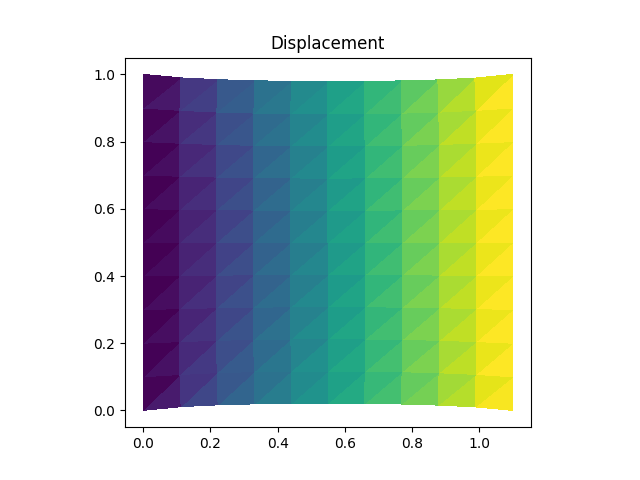

In [31]:
# show the result
from IPython.display import Image
Image('./Mechanics/displacement.png')

In [32]:
user_proxy.send(
    recipient=manager,
    message="""Let's change the boundary condition on the right edge to a shear case,
    i.e., the displacement along y direction is 0.1m on the right edge.
    Please refine the mesh to 50-by-50 elements, solve the problem again and save result into another png file.""",
)

Admin (to chat_manager):

Let's change the boundary condition on the right edge to a shear case,
    i.e., the displacement along y direction is 0.1m on the right edge.
    Please refine the mesh to 50-by-50 elements, solve the problem again and save result into another png file.

--------------------------------------------------------------------------------
Planner (to chat_manager):

Plan:

1. The scientist will provide the new boundary condition and the new mesh size. This information is already provided in the problem statement.

2. The engineer will then update the boundary condition and the mesh size in the FENICS model. This will involve changing the definition of the right boundary condition and the mesh size.

3. The engineer will then solve the problem using FENICS. This will involve running the solver to find the displacement of the elastic plate.

4. Once the displacement has been found, the engineer will then visualize the results using a suitable visualization tool, suc

Executor (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 
Solving linear variational problem.


--------------------------------------------------------------------------------
Scientist (to chat_manager):

The code has been executed successfully and the displacement of the elastic plate under the new boundary condition has been calculated. The results have been saved in a PNG file named "displacement_shear.png". Please review the results and let me know if any changes are needed.

--------------------------------------------------------------------------------
Critic (to chat_manager):

The plan and execution seem to be in order. However, there are a few points that could be improved:

1. The plan does not include a step for verifying the results. It's important to check the results against a known solution or an analytical solution if one is available. This could be added as a step after the displacement has been calculated.

2. The code does not include any error 

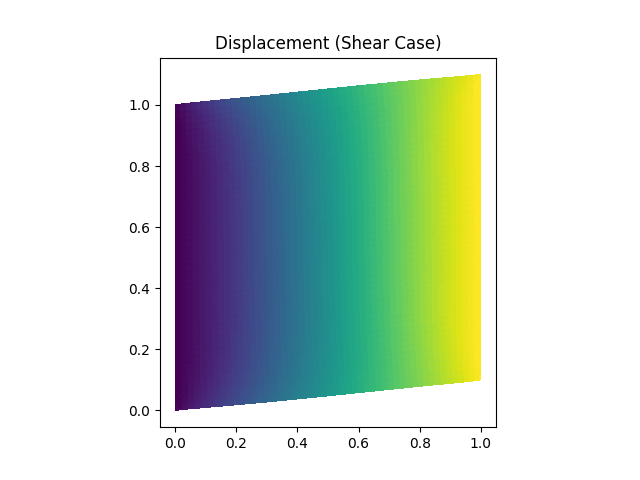

In [33]:
# show the result: it finished run even though not finishing the chat
# from IPython.display import Image
Image('./Mechanics/displacement_shear.png')

In [34]:
# check understanding the geometery
#
user_proxy.send(
    recipient=manager,
    message="""Let's add a circular hole of radius 0.2m in the middle of the original square domain.
    Please solve the share problem and save result into another png file.""",
)

Admin (to chat_manager):

Let's add a circular hole of radius 0.2m in the middle of the original square domain.
    Please solve the share problem and save result into another png file.

--------------------------------------------------------------------------------
Planner (to chat_manager):

Plan:

1. The scientist will provide the new geometry for the problem, which includes a circular hole in the middle of the square domain. This information is already provided in the problem statement.

2. The engineer will then update the geometry in the FENICS model. This will involve defining a new domain that includes the circular hole.

3. The engineer will then solve the problem using FENICS. This will involve running the solver to find the displacement of the elastic plate.

4. Once the displacement has been found, the engineer will then visualize the results using a suitable visualization tool, such as matplotlib. This will involve creating a plot of the displacement, and saving this plot

Executor (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 
Solving linear variational problem.


--------------------------------------------------------------------------------
Scientist (to chat_manager):

The code has been executed successfully and the displacement of the elastic plate with a hole in the middle under the shear condition has been calculated. The results have been saved in a PNG file named "displacement_shear_hole.png". Please review the results and let me know if any changes are needed.

--------------------------------------------------------------------------------
Critic (to chat_manager):

The plan and execution seem to be in order. However, there are a few points that could be improved:

1. The plan does not include a step for verifying the results. It's important to check the results against a known solution or an analytical solution if one is available. This could be added as a step after the displacement has been calculated.

2. The code doe

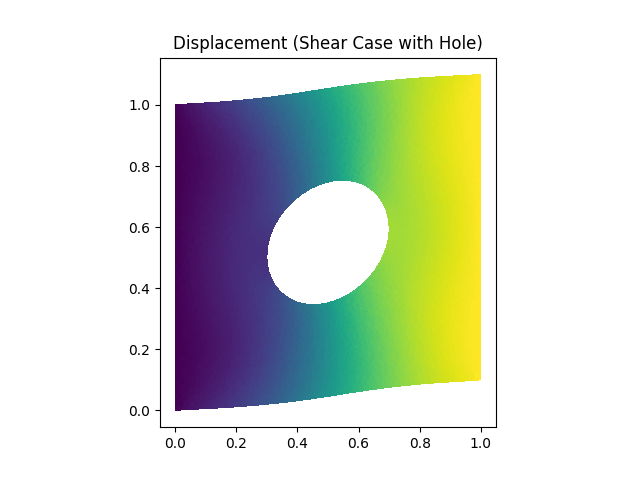

In [35]:
Image('./Mechanics/displacement_shear_hole.png')

#### check something more challenge

In [36]:
# check understanding the geometery
#
user_proxy.send(
    recipient=manager,
    message="""Let's also calculate the stress component sigma_xy and save it into another png file.""",
)

Admin (to chat_manager):

Let's also calculate the stress component sigma_xy and save it into another png file.

--------------------------------------------------------------------------------
Planner (to chat_manager):

Plan:

1. The scientist will provide the new requirement, which is to calculate the stress component sigma_xy. This information is already provided in the problem statement.

2. The engineer will then update the FENICS model to calculate the stress component sigma_xy. This will involve adding a new calculation to the script.

3. The engineer will then solve the problem using FENICS. This will involve running the solver to find the stress component sigma_xy.

4. Once the stress component has been found, the engineer will then visualize the results using a suitable visualization tool, such as matplotlib. This will involve creating a plot of the stress component, and saving this plot as a new PNG file.

5. The engineer will then provide the new PNG file to the scientist 

Executor (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


--------------------------------------------------------------------------------
Scientist (to chat_manager):

The code has been executed successfully and the stress component sigma_xy of the elastic plate with a hole in the middle under the shear condition has been calculated. The results have been saved in a PNG file named "stress_component_sigma_xy.png". Please review the results and let me know if any changes are needed.

--------------------------------------------------------------------------------
Critic (to chat_manager):

The plan and exec

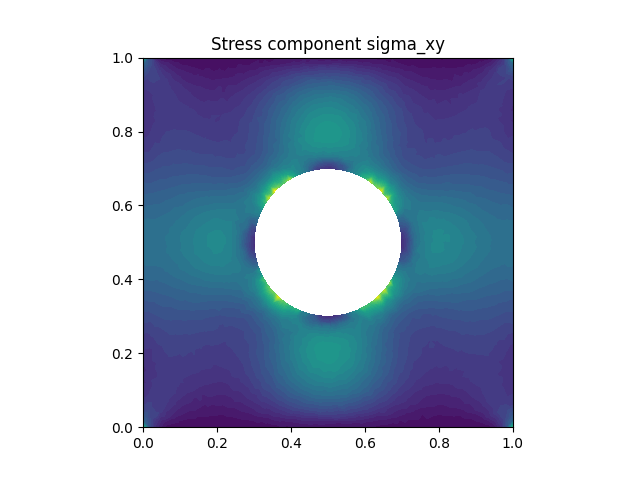

In [37]:
Image('./Mechanics/stress_component_sigma_xy.png')

### Working code ends here

In [38]:
!ls ./Mechanics

displacement.png		      elastic_displacement_shear_hole000000.vtu
displacement_shear_hole.png	      elastic_displacement_shear_hole.pvd
displacement_shear.png		      elastic_displacement_shear.pvd
elastic_displacement000000.vtu	      elasticity
elastic_displacement_hole000000.vtu   elastic_stress_hole000000.vtu
elastic_displacement_hole.pvd	      elastic_stress_hole.pvd
elastic_displacement.pvd	      stress_component_sigma_xy.png
elastic_displacement_shear000000.vtu


In [39]:
!zip -r /content/GroupChat_Mechanics_file.zip /content/Mechanics

  adding: content/Mechanics/ (stored 0%)
  adding: content/Mechanics/displacement.png (deflated 18%)
  adding: content/Mechanics/displacement_shear.png (deflated 6%)
  adding: content/Mechanics/elastic_displacement_shear_hole.pvd (deflated 27%)
  adding: content/Mechanics/elastic_stress_hole.pvd (deflated 28%)
  adding: content/Mechanics/elastic_displacement_shear000000.vtu (deflated 72%)
  adding: content/Mechanics/stress_component_sigma_xy.png (deflated 4%)
  adding: content/Mechanics/elastic_displacement_shear.pvd (deflated 27%)
  adding: content/Mechanics/elastic_displacement.pvd (deflated 27%)
  adding: content/Mechanics/elastic_displacement000000.vtu (deflated 71%)
  adding: content/Mechanics/elastic_displacement_shear_hole000000.vtu (deflated 74%)
  adding: content/Mechanics/elastic_displacement_hole000000.vtu (deflated 65%)
  adding: content/Mechanics/displacement_shear_hole.png (deflated 3%)
  adding: content/Mechanics/elastic_displacement_hole.pvd (deflated 27%)
  adding: con

In [40]:
from google.colab import files

files.download("/content/GroupChat_Mechanics_file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>